# USABILITY TAGGER

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
import sys
import re

sys.path.append('../../utils')
import config_handling as conf
from database import Database
from file_io import path_handler
from cnn_helpers import preprocess_image, system_override

In [2]:
# Load configuration
config = conf.read_config('../../config/automotive.conf.ini')
config.read('config.ini')
connection_type = config['settings']['connection']
user = config[connection_type]['user']
pw = config[connection_type]['pw']
host = config[connection_type]['host']
db = config[connection_type]['db']
port = config[connection_type].getint('port')
db = Database(host,
              port,
              user,
              pw,
              db
              )
db.connect()

# Image directory
basedir = config['settings']['image_directory']

Connection established


## 1 Problem framing. 
Not all images are usefull to be part of the full classification pipeline, as such we want to get rid of these before we commence training. In some cases it's immediately apparent if an image is useful or not; pictures of keyfobs, tire thread, car seats... none of these help in the final goal of this project (i.e. identifying a car brand and model by exterior pictures. ) Some images clearly show the outside of a car, but show it in ways that'd not be helpful either: extreme close-ups or opened doors. These too are considered unusable. Finally there are photographs where the car is 'cropped' off to one or more sides. As a general rule these too will be flagged as unusable. 

## 2 Data.
No training data was available that could teach a model if an image is useful or not. To quickly generate this data, a Flask app was written which is part of this repo in `/flash angle tagger`. This tagger provides an HTML interface where crappy - vs non-crappy images could easily be marked by a click button or keyboard shortcut. If an image is considered to be usable, it'd receive one of eight possible angle-tags. The topic of angle tagging is discussed in notebook `2 - angle tagging.ipynb`. 

For an image to be considered usable, it had to fulfill the following requirements: 
1) The car should be fully visible on the image. (No cropping)
2) Obstruction is allowed, but should be kept within a reasonable amount. 
3) Doors, lids,... should be closed. 
4) Only exterior photographs are allowed. 

In total 20.000 images where manually tagged using this tool.

In [3]:
#check if you reacked 20K
db.execute_query('SELECT count(*) AS f FROM angletags WHERE angletags.manual_annotation = 1')

[{'f': 20000}]

### 2.1 A sample of unusable images

In [4]:
def plot_images_as_grid(imseries, title, n=4): 
    """
    creates a grid of n*n images by randomply picking n**2 images
    from a series object (imseries) and plots them into the notebook. 
    """
    samplesize = n**2
    chosen = imseries.sample(samplesize)
    fig, axes = plt.subplots(n, n, figsize=(12, 12))
    axes = axes.flatten()
    i = 0
    for image in chosen: 
        img = Image.open(image)
        axes[i].imshow(img)
        axes[i].axis('off')
        i+=1
    fig.suptitle(title, fontsize=16)

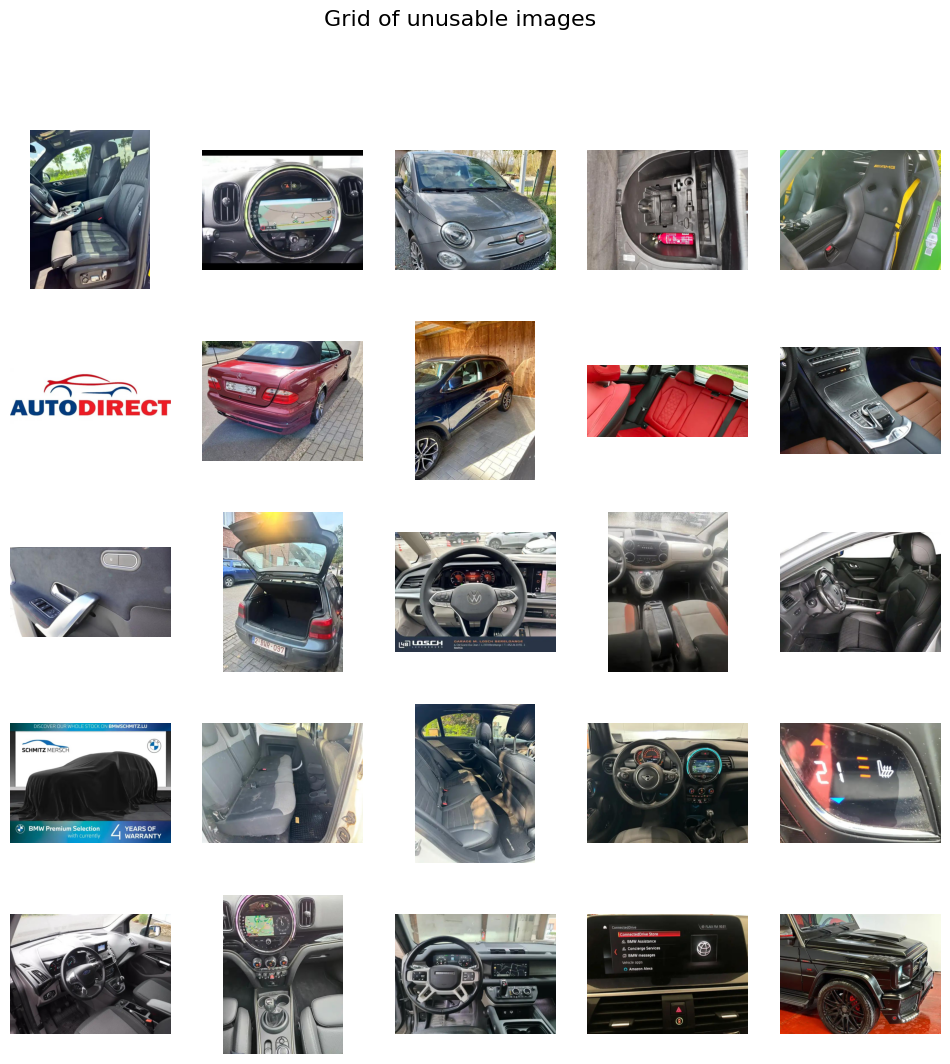

In [5]:
query = """ SELECT
                angletags.*,
                images.image_path
            FROM angletags 
            JOIN images ON images.id = angletags.image_id
            WHERE 
                angletags.manual_annotation = 1 AND
                angletags.angle = "crappy"; 
        """
unusable_data = db.execute_query(query)
crappy_df = pd.DataFrame(unusable_data)
crappy_df['image_path'] = crappy_df['image_path'].apply(lambda x: path_handler(basedir, x))
plot_images_as_grid(crappy_df['image_path'], 'Grid of unusable images', 5)

### 2.2 A sample of usable images

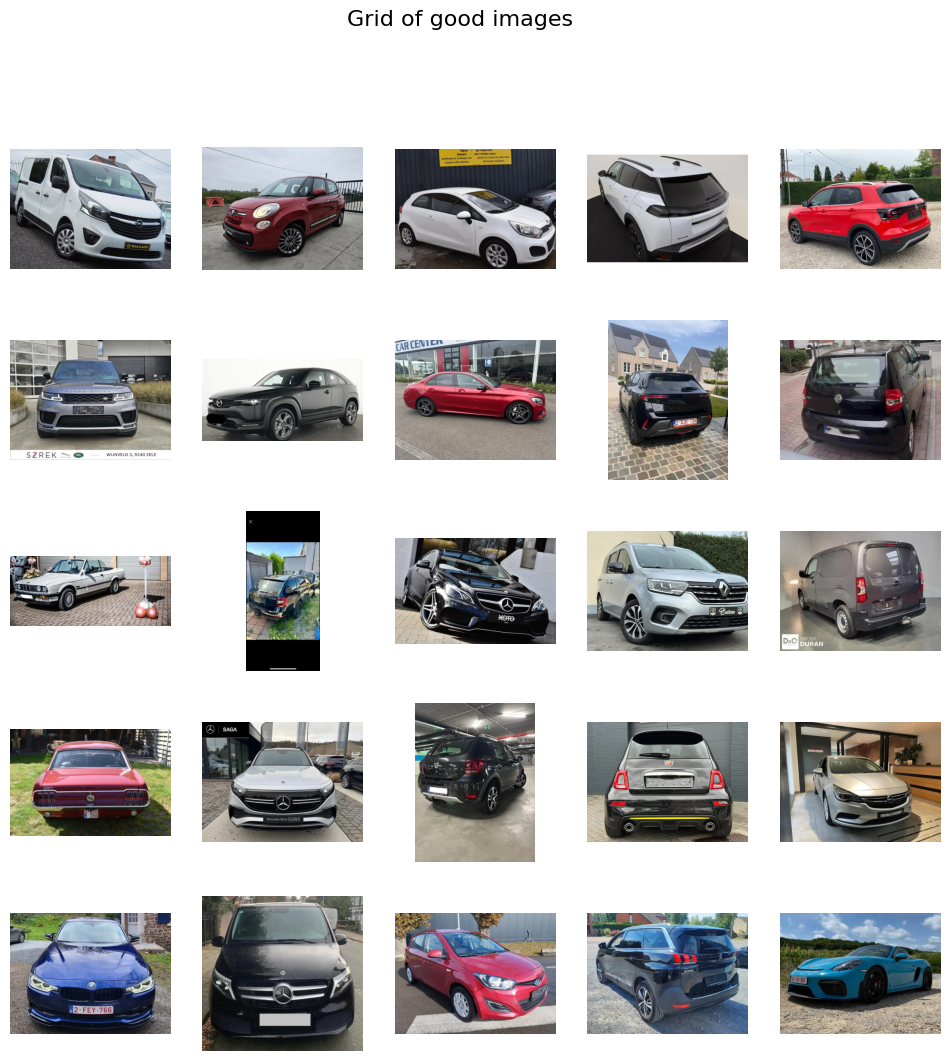

In [6]:
query = """ SELECT
                angletags.*,
                images.image_path
            FROM angletags 
            JOIN images ON images.id = angletags.image_id
            WHERE 
                angletags.manual_annotation = 1 AND
                angletags.angle <> "crappy"; 
        """
usable_data = db.execute_query(query)
good_df = pd.DataFrame(usable_data)
good_df['image_path'] = good_df['image_path'].apply(lambda x: path_handler(basedir, x))
plot_images_as_grid(good_df['image_path'], 'Grid of good images',5)

The two grids above of 5 by 5 each illustrate the outcome applying all rules. About 20.000 images where manually tagged. The outcome of this proces is as follows: 

Text(0.5, 1.0, 'Image usability of manually tagged data')

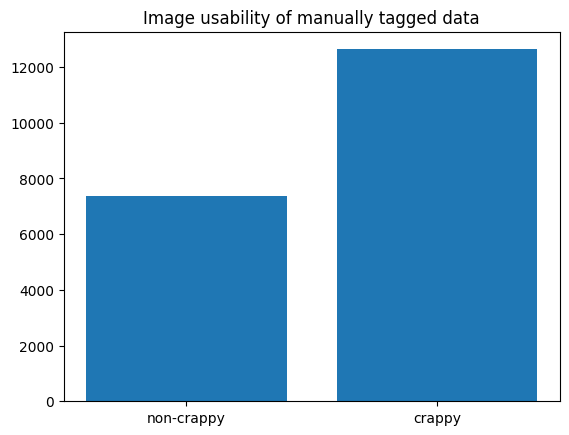

In [7]:
query = """SELECT
                COUNT(*) AS f,
                CASE
                    WHEN angletags.angle = 'crappy' THEN 'crappy'
                    ELSE 'non-crappy'
                END AS usability
            FROM angletags
            WHERE angletags.manual_annotation = 1
            GROUP BY usability
            HAVING usability IN ('crappy', 'non-crappy')
        """
angle_distribution_data = db.execute_query(query)
angle_df = pd.DataFrame(angle_distribution_data)
plt.bar(angle_df['usability'], angle_df['f'])
plt.title('Image usability of manually tagged data')

## 3. Model training: 
We do not know how many images we need to tag for a model to pick up the differences between a usable and unusable image. To figure this out, we'll go through our manually tagged data and gradually increase the amount of data our model is trained on. 

To do this, we'll start with splitting our data and keep a validation set to the side. This validation set will be used by every trained model to measure how well it performs. 

The part of the data that's not in the validation set will be used to train models, each model will see more data than the previous one. Our trainingsdata will start with seeing 5% of the data and grow with 5% increments each time. For every round of model training, we'll try to measure how precise the model is. We know that we've fed sufficient training data to our model if two consecutive training sets do not show any performance gain any longer. 

At this stage we also have our bounding boxes available, so we'll see if this makes the model perform better or not. 

In [8]:
system_override()

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    device = 'GPU'
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
else:
    device = 'CPU'

# Print the device being used
print(f"Using {device} for deep learning.")

System override applied - check if GPU is detected
Using GPU for deep learning.


2025-02-03 11:56:36.300817: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-03 11:56:38.836495: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-03 11:56:38.836561: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [9]:
# Get the data from MYSQL and into a pandas DataFrame: 
tagged_data_query = """ SELECT
                angletags.angle,
                images.image_path, 
                images.yolobox_top_left_x AS x1,
                images.yolobox_top_left_y AS y1,
                images.yolobox_bottom_right_x AS x2,
                images.yolobox_bottom_right_y AS y2
            FROM angletags 
            JOIN images ON images.id = angletags.image_id
            WHERE 
                angletags.manual_annotation = 1;
        """
tagged_usability_data = db.execute_query(tagged_data_query)
tagged_df = pd.DataFrame(tagged_usability_data)
#add the fully qualified paths: 
tagged_df['image_path'] = tagged_df['image_path'].apply(lambda x: path_handler(basedir, x))
#where no bounding box was made, the database holds NULL, (pandas NaN); 
# so fillna() with sentinel value
tagged_df = tagged_df.fillna(-1)
#enforce integers for bbox coords: 
tagged_df[['x1', 'y1', 'x2', 'y2']] = tagged_df[['x1', 'y1', 'x2', 'y2']].astype(int)
# encode an y:
tagged_df['usable_image'] = tagged_df['angle'].apply(lambda x: 0 if x == 'crappy' else 1)
# drop angle:
tagged_df.drop(columns=['angle'])



image_path   x1   y1   x2   y2  \
0      /home/frederic/Documents/automotive_image_data...    1  118  658  500   
1      /home/frederic/Documents/automotive_image_data...   -1   -1   -1   -1   
2      /home/frederic/Documents/automotive_image_data...  140  150  687  555   
3      /home/frederic/Documents/automotive_image_data...    2  161  422  564   
4      /home/frederic/Documents/automotive_image_data...   -1   -1   -1   -1   
...                                                  ...  ...  ...  ...  ...   
19995  /home/frederic/Documents/automotive_image_data...   -1   -1   -1   -1   
19996  /home/frederic/Documents/automotive_image_data...   -1   -1   -1   -1   
19997  /home/frederic/Documents/automotive_image_data...   -1   -1   -1   -1   
19998  /home/frederic/Documents/automotive_image_data...   -1   -1   -1   -1   
19999  /home/frederic/Documents/automotive_image_data...   -1   -1   -1   -1   

       usable_image  
0                 1  
1                 0  
2                 1  
3                 0  
4                 0  
...             ...  
19995             0  
19996             0  
19997             0  
19998             0  
19999             0  

[20000 rows x 6 columns]

In [10]:
# Take a part of your data out to use as validation. Use a stratified split on the 'angle' column
#    YES... I know we already use angle, but it's not a problem; any angle that is not crappy is considered good.
#    so your stratified split woudl more or less be the same anyway. 
rs = 42
X = tagged_df.drop(columns=['usable_image'])
y = tagged_df['usable_image']
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=rs, stratify=tagged_df['angle'])

the X_validation and y_validation will not be used for training, only for evaluating every loop!

In [11]:
batch_size = 32
model_dir = os.path.join(os.getcwd(), '../../models/bin_models')

In [12]:
os.makedirs(model_dir, exist_ok=True)

In [13]:
# start the experiment with data volume; also experiment with using or dismissing bounding boxes.
## TQDM is useless here, but this experiment should last: ((sum(fractions)/0.05) * 2) * first loop time 
# you could theoretically speed this up by not always resampling from X_train and y_train and just add 0.05 each time
# but I want to have the variety (in the small sample sizes). 

#fractions = how big of a part of the data will you work on? This includes Train and Test data.
fractions = np.linspace(0.05, 1, 10)
#Boolean: do you use the bounding boxes of YOLO or not?
use_bboxes = [True, False]
#how many times to feed the data through the model?
epochs_count = [5, 10]
#how big is a grid of an image?
imsizess_on_one_dim = [64, 128]
#set the random state for tensorflow too to allow reproducitbility and pickup after interuption in training: 
tf.random.set_seed(rs)

for imsize_single_dim in imsizess_on_one_dim:
    binary_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(imsize_single_dim, imsize_single_dim, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(imsize_single_dim, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(imsize_single_dim*2, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    binary_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    for epochs in epochs_count: 
        for fraction in fractions:
            # Take fraction% of the data from X_train and y_train
            sampled_X = X_train.sample(frac=fraction, random_state=rs)
            sampled_y = y_train.loc[sampled_X.index]
            #now you have a fraction of the whole; use standard practics
            for use_bounding_boxes in use_bboxes:
                name = f"fracsize={fraction}__bbox={use_bounding_boxes}__imsize_sqrd={imsize_single_dim}__epochs={epochs}.keras"
                if name in os.listdir(model_dir): 
                    #allow interuption, everything has a set random state, so this isn't an issue.
                    continue
                images = []
                for _, row in sampled_X.iterrows():
                    #print(row)
                    bbox = (row['x1'], row['y1'], row['x2'], row['y2'])
                    img = preprocess_image(row['image_path'], use_bounding_boxes, bbox, imsize_single_dim)
                    images.append(img)
                images = np.array(images)  # you can't pass a list, but need to pass np array or a tensor!!: ((https://stackoverflow.com/questions/63527536/passing-a-python-list-to-keras-model-fit))
                sampled_y = np.array(sampled_y)  # just to be sure. 
                binary_model.fit(
                                    images, 
                                    sampled_y, 
                                    epochs=epochs, 
                                    batch_size=batch_size, 
                                    validation_split=0.2
                                )
                saveto = os.path.join(model_dir, name)
                binary_model.save(saveto)
                with open(os.path.join(model_dir, 'model_notes.txt'), 'a+') as logfile: 
                    logfile.write(f"{saveto}, {len(images)}, {epochs}, {imsize_single_dim}, {batch_size}\n")
                    logfile.flush()





/home/frederic/Documents/automotive_project/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-03 10:52:12.541216: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-03 10:52:12.541374: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-03 10:52:12.541432: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but ther

Epoch 1/5


I0000 00:00:1738576334.874904  120470 service.cc:146] XLA service 0x7f80e800c530 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738576334.874947  120470 service.cc:154]   StreamExecutor device (0): AMD Radeon RX 6700 XT, AMDGPU ISA version: gfx1030
2025-02-03 10:52:14.896771: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 9/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4605 - loss: 0.9241 

I0000 00:00:1738576338.035441  120470 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5279 - loss: 0.8506 - val_accuracy: 0.6875 - val_loss: 0.6028
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7009 - loss: 0.5790 - val_accuracy: 0.7563 - val_loss: 0.5139
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8278 - loss: 0.4422 - val_accuracy: 0.8562 - val_loss: 0.3868
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8834 - loss: 0.3223 - val_accuracy: 0.8375 - val_loss: 0.3676
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9163 - loss: 0.2299 - val_accuracy: 0.8438 - val_loss: 0.3803
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7711 - loss: 0.5186 - val_accuracy: 0.8250 - val_loss: 0.4390
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8695 - loss: 0.3233 - val_accuracy: 0.8375 - val_loss: 0.3480
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9375 - loss: 0.2221 - val_accuracy: 0.8438 - val_loss: 0.3282
Epoch 4/5

2025-02-03 11:09:18.376912: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2250768384 exceeds 10% of free system memory.


Epoch 1/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9624 - loss: 0.1401 - val_accuracy: 0.9336 - val_loss: 0.1931
Epoch 2/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9878 - loss: 0.0422 - val_accuracy: 0.9441 - val_loss: 0.1947
Epoch 3/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9934 - loss: 0.0249 - val_accuracy: 0.9438 - val_loss: 0.2665
Epoch 4/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9953 - loss: 0.0167 - val_accuracy: 0.9410 - val_loss: 0.2857
Epoch 5/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.9975 - loss: 0.0106 - val_accuracy: 0.9329 - val_loss: 0.2877


2025-02-03 11:10:52.787643: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2250768384 exceeds 10% of free system memory.


Epoch 1/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9850 - loss: 0.0586 - val_accuracy: 0.9343 - val_loss: 0.2389
Epoch 2/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9937 - loss: 0.0232 - val_accuracy: 0.9260 - val_loss: 0.3993
Epoch 3/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9942 - loss: 0.0175 - val_accuracy: 0.9392 - val_loss: 0.3187
Epoch 4/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9989 - loss: 0.0038 - val_accuracy: 0.9354 - val_loss: 0.3313
Epoch 5/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9989 - loss: 0.0059 - val_accuracy: 0.9329 - val_loss: 0.3081


2025-02-03 11:12:02.525605: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2516582400 exceeds 10% of free system memory.


Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9863 - loss: 0.0495 - val_accuracy: 0.9359 - val_loss: 0.2227
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9945 - loss: 0.0211 - val_accuracy: 0.9406 - val_loss: 0.2588
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9980 - loss: 0.0064 - val_accuracy: 0.9409 - val_loss: 0.2720
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.9984 - loss: 0.0070 - val_accuracy: 0.9419 - val_loss: 0.2702
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9974 - loss: 0.0070 - val_accuracy: 0.9444 - val_loss: 0.3086


2025-02-03 11:13:29.023650: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2516582400 exceeds 10% of free system memory.


Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9874 - loss: 0.0422 - val_accuracy: 0.9237 - val_loss: 0.2826
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9946 - loss: 0.0151 - val_accuracy: 0.9266 - val_loss: 0.2762
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.9979 - loss: 0.0075 - val_accuracy: 0.9353 - val_loss: 0.3077
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9976 - loss: 0.0085 - val_accuracy: 0.9334 - val_loss: 0.3192
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9984 - loss: 0.0038 - val_accuracy: 0.9216 - val_loss: 0.4118
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9999 - loss: 0.0027 - val_accuracy: 0.9937 - val_loss: 0.0067
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 1.0000 - loss: 7.9784e-04 - val_accuracy: 1.0000 - val_loss: 8.9165e-04
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 2.6222e-04 - val_

2025-02-03 11:37:51.116731: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2250768384 exceeds 10% of free system memory.


Epoch 1/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.9944 - loss: 0.0237 - val_accuracy: 0.9570 - val_loss: 0.3619
Epoch 2/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9985 - loss: 0.0124 - val_accuracy: 0.9630 - val_loss: 0.3204
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9993 - loss: 0.0041 - val_accuracy: 0.9619 - val_loss: 0.3292
Epoch 4/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9995 - loss: 0.0019 - val_accuracy: 0.9637 - val_loss: 0.3441
Epoch 5/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9992 - loss: 0.0027 - val_accuracy: 0.9616 - val_loss: 0.3821
Epoch 6/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9993 - loss: 0.0038 - val_accuracy: 0.9640 - val_loss: 0.2983
Epoch 7/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9978 - loss: 0.0106 - val_accuracy: 0.9577 - val_loss: 0.3357
Epoch 8/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9991 - loss: 0.0038 - val_ac

## 4. Model evaluation
We've trained a ton of models with different parameters and data sizes. Our goal is to see what the best performing combination of variables is. For this we focus on a single metric: F1-score and do a prediction for our original testdata that was split off at section 3. The goal is to plot out the evolution of the F1-score as the size of the dataset for training grows.

In this phase we need to pay close attention to the following: 
- testing pipeline shoudl mimmick training pipeline (image size AND bounding box dependency)
- Good logging.
- Force the predictions to use GPU too!!!

In [36]:
trained_models = [file for file in os.listdir(model_dir) if file.endswith('.keras')]
len(trained_models)

80

In [39]:
def parse_model_filename(filename):
    if filename.endswith('.keras'):
        print(filename)
        pattern = r"fracsize=(\d+\.\d+)__bbox=(True|False)__imsize_sqrd=(\d+)__epochs=(\d+)"
        match = re.match(pattern, filename)
        if match:
            return {
                'fracsize': float(match.group(1)),
                'bbox': match.group(2) == 'True',
                'imsize': int(match.group(3)),
                'epochs': int(match.group(4)),
                'filename': filename
            }
# Group models based on bbox, imsize, and epochs, then you can iterate over ever growing datasize to plot performance.
models_parsed = [parse_model_filename(model) for model in trained_models]
models_parsed_sorted = sorted(
    models_parsed,
    key=lambda x: (x['bbox'], x['imsize'], x['epochs'], x['fracsize'])
)
#Group using multiple keys (the parameters that were for-loops earlier)
grouped_models = {}
for model in models_parsed_sorted:
    key = (model['bbox'], model['imsize'], model['epochs'])
    if key not in grouped_models:
        grouped_models[key] = []
    grouped_models[key].append(model['filename'])

fracsize=0.05__bbox=False__imsize_sqrd=128__epochs=5.keras
fracsize=0.5777777777777778__bbox=True__imsize_sqrd=128__epochs=10.keras
fracsize=0.8944444444444445__bbox=False__imsize_sqrd=128__epochs=5.keras
fracsize=0.15555555555555556__bbox=True__imsize_sqrd=128__epochs=10.keras
fracsize=0.05__bbox=True__imsize_sqrd=64__epochs=5.keras
fracsize=0.8944444444444445__bbox=False__imsize_sqrd=64__epochs=5.keras
fracsize=0.788888888888889__bbox=True__imsize_sqrd=128__epochs=10.keras
fracsize=0.05__bbox=False__imsize_sqrd=64__epochs=5.keras
fracsize=0.6833333333333333__bbox=True__imsize_sqrd=64__epochs=10.keras
fracsize=0.6833333333333333__bbox=True__imsize_sqrd=64__epochs=5.keras
fracsize=0.2611111111111111__bbox=False__imsize_sqrd=64__epochs=10.keras
fracsize=0.4722222222222222__bbox=True__imsize_sqrd=128__epochs=10.keras
fracsize=0.6833333333333333__bbox=False__imsize_sqrd=128__epochs=5.keras
fracsize=0.36666666666666664__bbox=True__imsize_sqrd=64__epochs=5.keras
fracsize=0.4722222222222222_

In [64]:
fracpattern = r"fracsize=([\d\.]+)"
all_predictions = {}
for key, models in grouped_models.items():
    all_predictions[key] = []
    print(key)
    use_bbox_str = key[0]
    use_bbox = use_bbox_str == 'True'
    rastersize = key[1]
    epochs = key[2] #to add to plot legend.
    #now, use the model with the right preprocessing requirements from the key to preprocess the images:
    #every model with this key, has the same preprocessing, so do it here, then test model performance (does size matter?)
    images = []
    for _, row in X_validation.iterrows():
        #print(row)
        bbox = (row['x1'], row['y1'], row['x2'], row['y2'])
        img = preprocess_image(row['image_path'], use_bbox, bbox, rastersize)
        images.append(img)
    for model_name in models:
        trainsize = float(re.search(fracpattern, model_name).group(1))
        model = load_model(os.path.join(model_dir, model_name))
        images = np.array(images)
        predictions = model.predict(images)
        all_predictions[key].append(predictions)

(False, 64, 5)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(False, 64, 10)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(False, 128, 5)
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━

In [65]:
del(model)

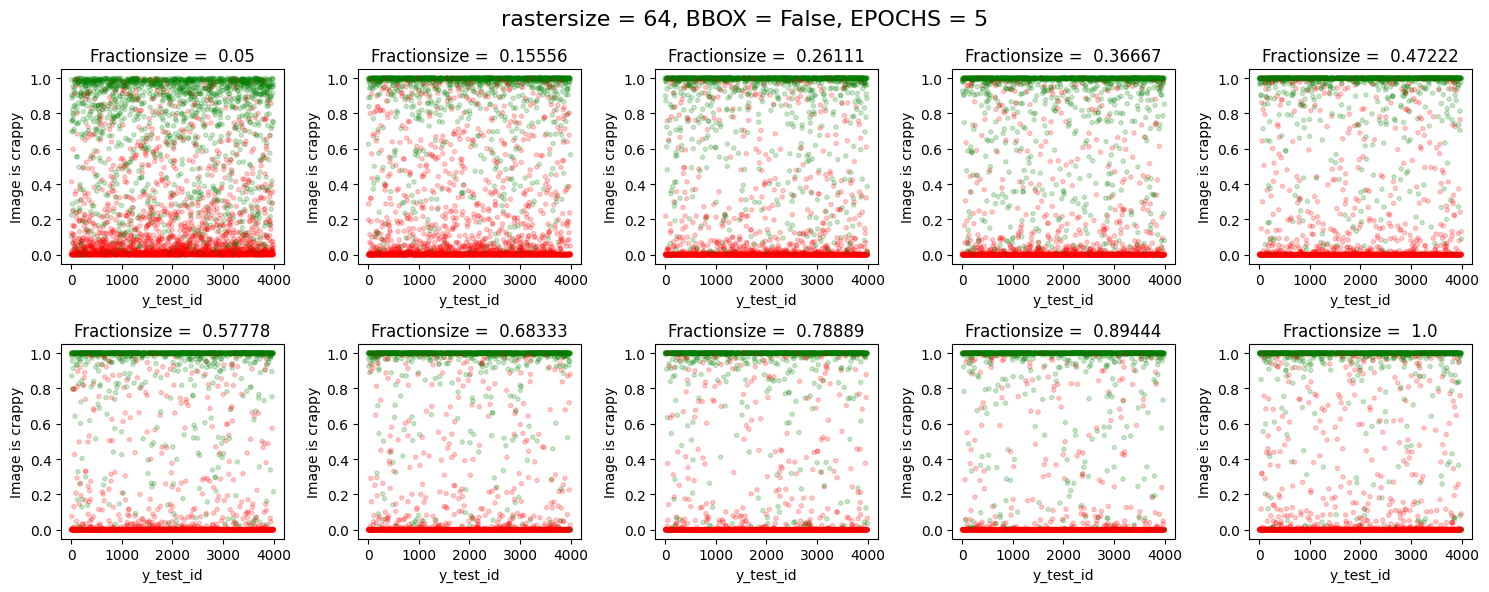

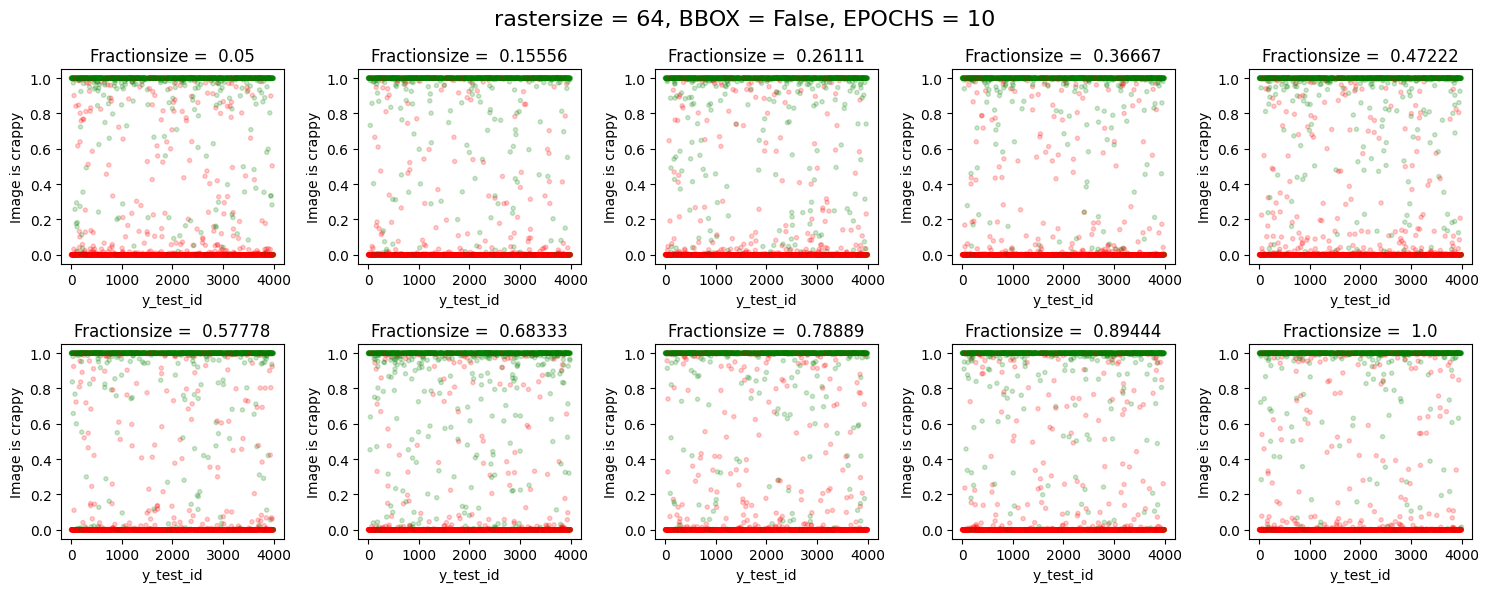

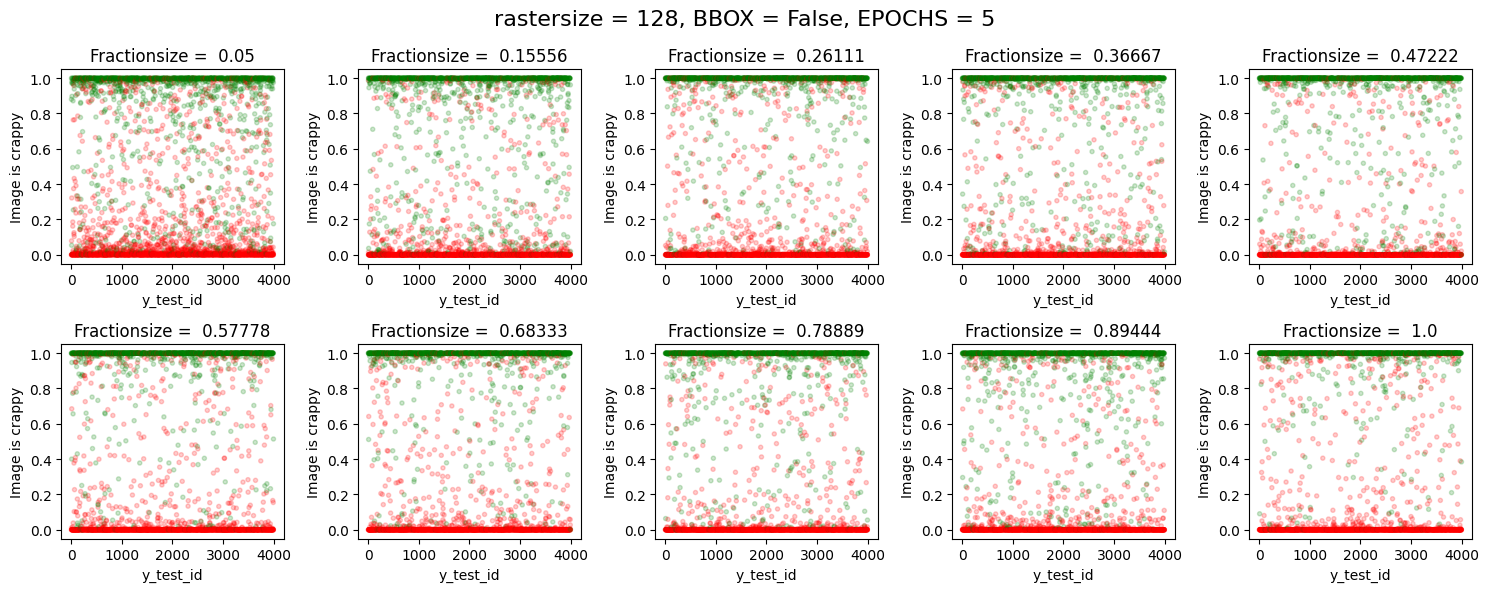

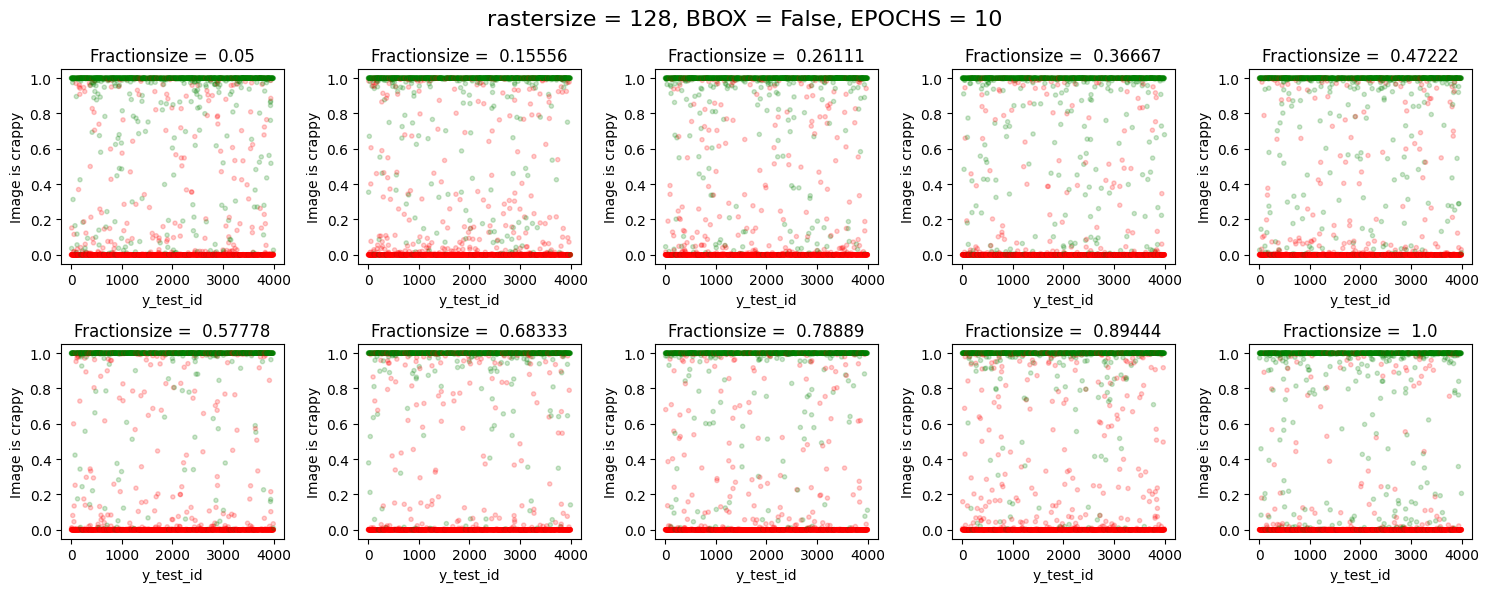

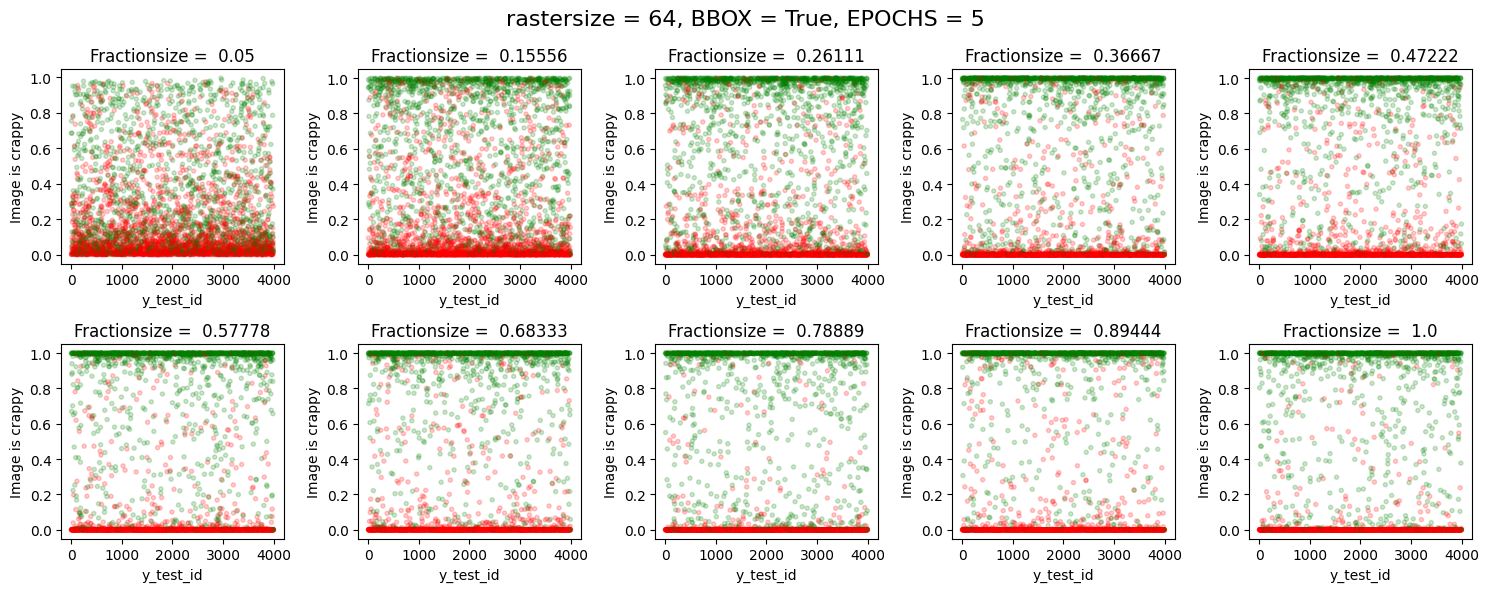

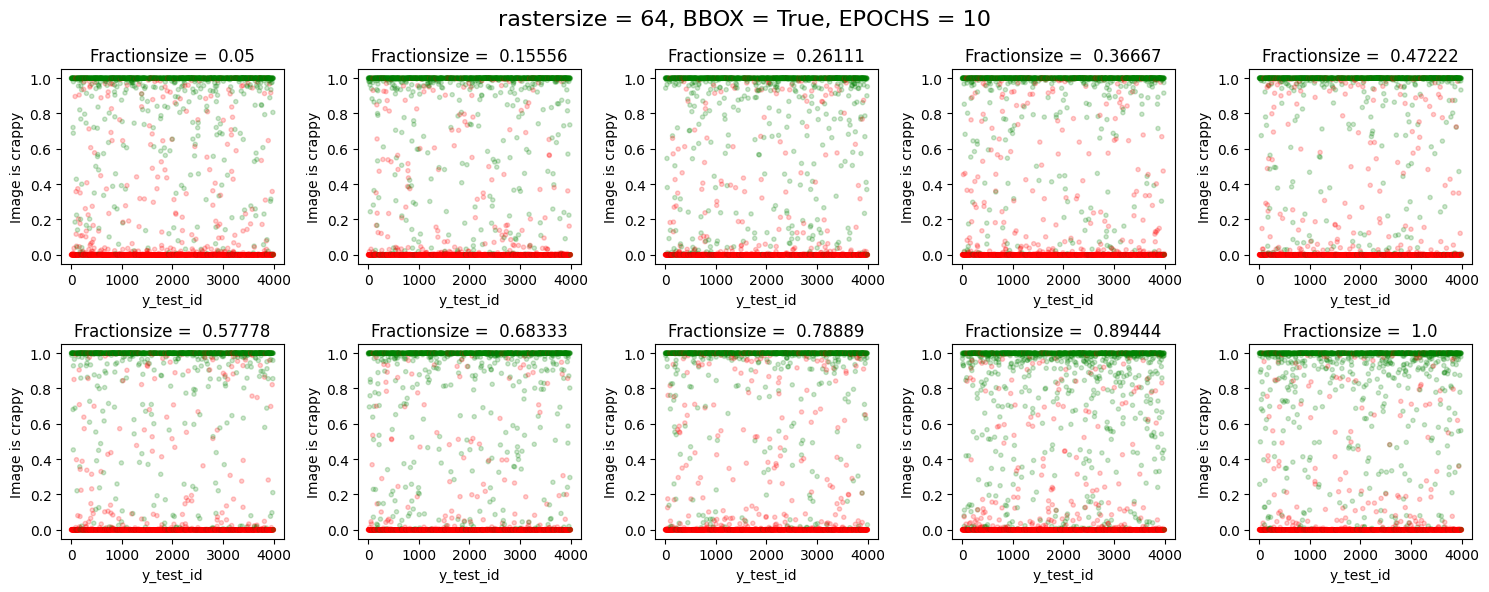

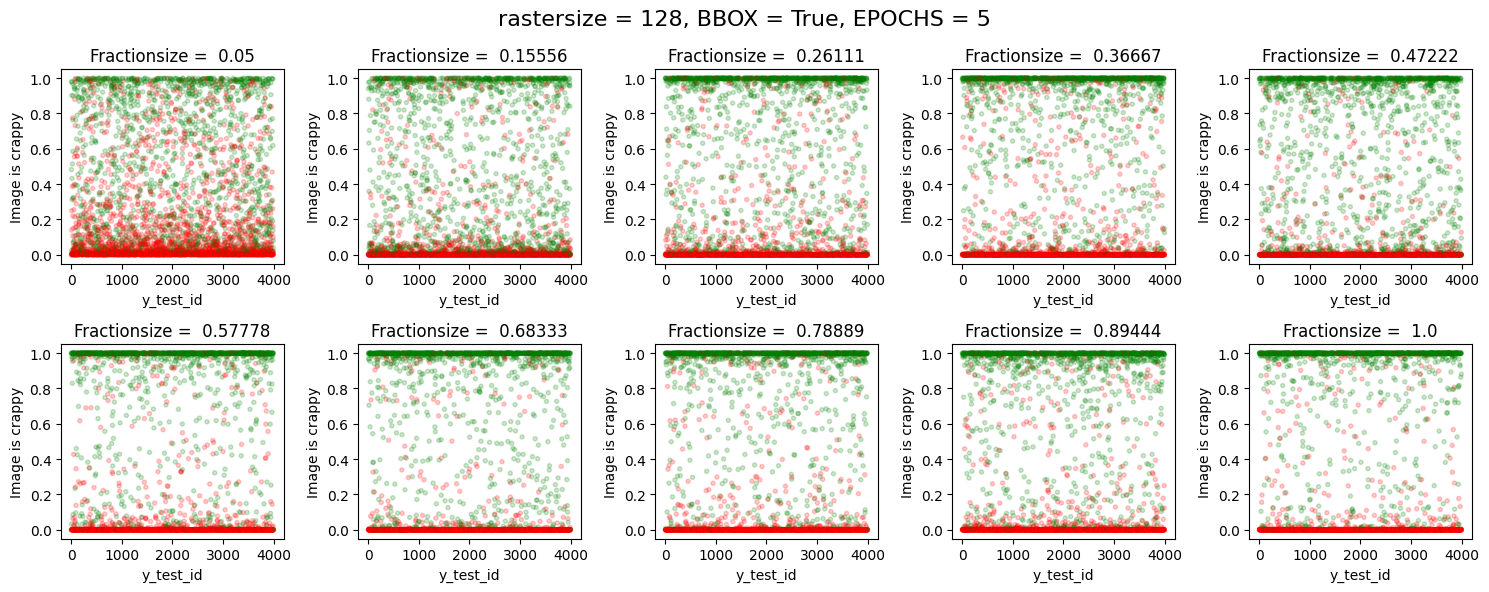

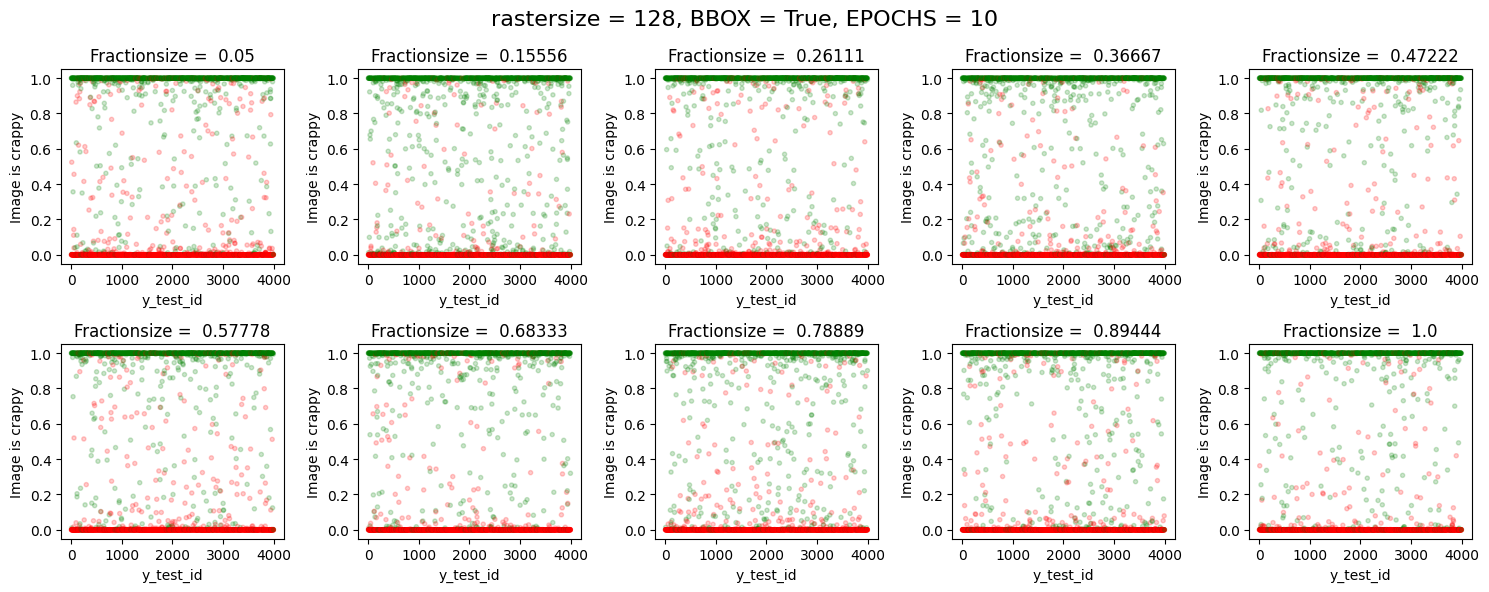

In [91]:
for key, predictions in all_predictions.items():
    suptitle_name = f"rastersize = {key[1]}, BBOX = {key[0]}, EPOCHS = {key[2]}"
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    #scatter how the certainty level of predictions change as trainsize grows: 
    colors = ['green' if y_validation.iloc[i] == 1 else 'red' for i in range(len(predicts))]
    for idx, predicts in enumerate(predictions):
            ax = axes[idx]
            ax.scatter(
                x = range(len(predicts)), 
                y = predicts, 
                marker='.', 
                c = colors, 
                alpha= 0.2
            )
            ax.set_title(f"Fractionsize =  {round(fractions[idx], 5)}")
            ax.set_xlabel('y_test_id')
            ax.set_ylabel('Image is crappy')
    plt.suptitle(suptitle_name, fontsize=16)
    plt.tight_layout()

Scatter conclusion: 

- more is better when it comes to **epochs** and **fractionsize**. Although, all models with ten epochs seem to care less about fractionsizes.
- from the scatter it's not clear if the use of **Bounding boxes** and **bigger raster** have a profound effect. From training we found that a bigger raster is a significant slowdown (logicall because raster of 64 is four times smaller than a raster of 128) 64<sup>2</sup> vs 128<sup>2</sup>

We don't have a cutoff yet, we need to decide which level of crapiness certainty is our treshold, standard you'd say 0.5; but we'll experiment with this. There are almost 16.000.000 images in the dataset, I care more about limiting false positives, then I care about false negatives.  (I.e. I don't want that an image of a key is mistaken for a car, but if a car is accidentally considered to be useless - so be it)

There is no way iin hell that this model will be able to perfectly distinguish all crappy and all non-crappy images from each other. This was also difficult for a human expert - because sometimes only a very small part of the car was cut off, and this made me doubt whether or not it should be crappy, furthermore, sometimes the car is fully visible on the image, but YOLO makes a too tight bounding box (i.e. good image, too tight YOLO-crop), a model could flag this as crappy, but it is in fact a good image. We're not aiming for perfect, but good enough. 

In [123]:
cutoff_points = [0.5, 0.75, 0.9, 0.95]
bin_results = {}
for cutoff in cutoff_points: 
    bin_results[cutoff] = {}
    for key, predictions in all_predictions.items():
        print(key)
        bin_results[cutoff][key] = {
            'TN': [],
            'TP': [],
            'FN': [],
            'FP': [],
            'precision': [], 
            'recall': [],
            'F1': []
        }
        for predict in predictions: 
            bin_predict = [1 if p > cutoff else 0 for p in predict]
            tn = sum(1 for p, y in zip(bin_predict, y_validation) if p == 0 and y == 0)
            tp = sum(1 for p, y in zip(bin_predict, y_validation) if p == 1 and y == 1)
            fn = sum(1 for p, y in zip(bin_predict, y_validation) if p == 0 and y == 1)
            fp = sum(1 for p, y in zip(bin_predict, y_validation) if p == 1 and y == 0)

            #Precision and recall
            precision = tp / (tp + fp) if (tp + fp) != 0 else 0
            recall = tp / (tp + fn) if (tp + fn) != 0 else 0
            # F1 score
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
            
            bin_results[cutoff][key]['TN'].append(tn)
            bin_results[cutoff][key]['TP'].append(tp)
            bin_results[cutoff][key]['FN'].append(fn)
            bin_results[cutoff][key]['FP'].append(fp)
            bin_results[cutoff][key]['precision'].append(precision)
            bin_results[cutoff][key]['recall'].append(recall)
            bin_results[cutoff][key]['F1'].append(f1)
           


(False, 64, 5)
(False, 64, 10)
(False, 128, 5)
(False, 128, 10)
(True, 64, 5)
(True, 64, 10)
(True, 128, 5)
(True, 128, 10)
(False, 64, 5)
(False, 64, 10)
(False, 128, 5)
(False, 128, 10)
(True, 64, 5)
(True, 64, 10)
(True, 128, 5)
(True, 128, 10)
(False, 64, 5)
(False, 64, 10)
(False, 128, 5)
(False, 128, 10)
(True, 64, 5)
(True, 64, 10)
(True, 128, 5)
(True, 128, 10)
(False, 64, 5)
(False, 64, 10)
(False, 128, 5)
(False, 128, 10)
(True, 64, 5)
(True, 64, 10)
(True, 128, 5)
(True, 128, 10)


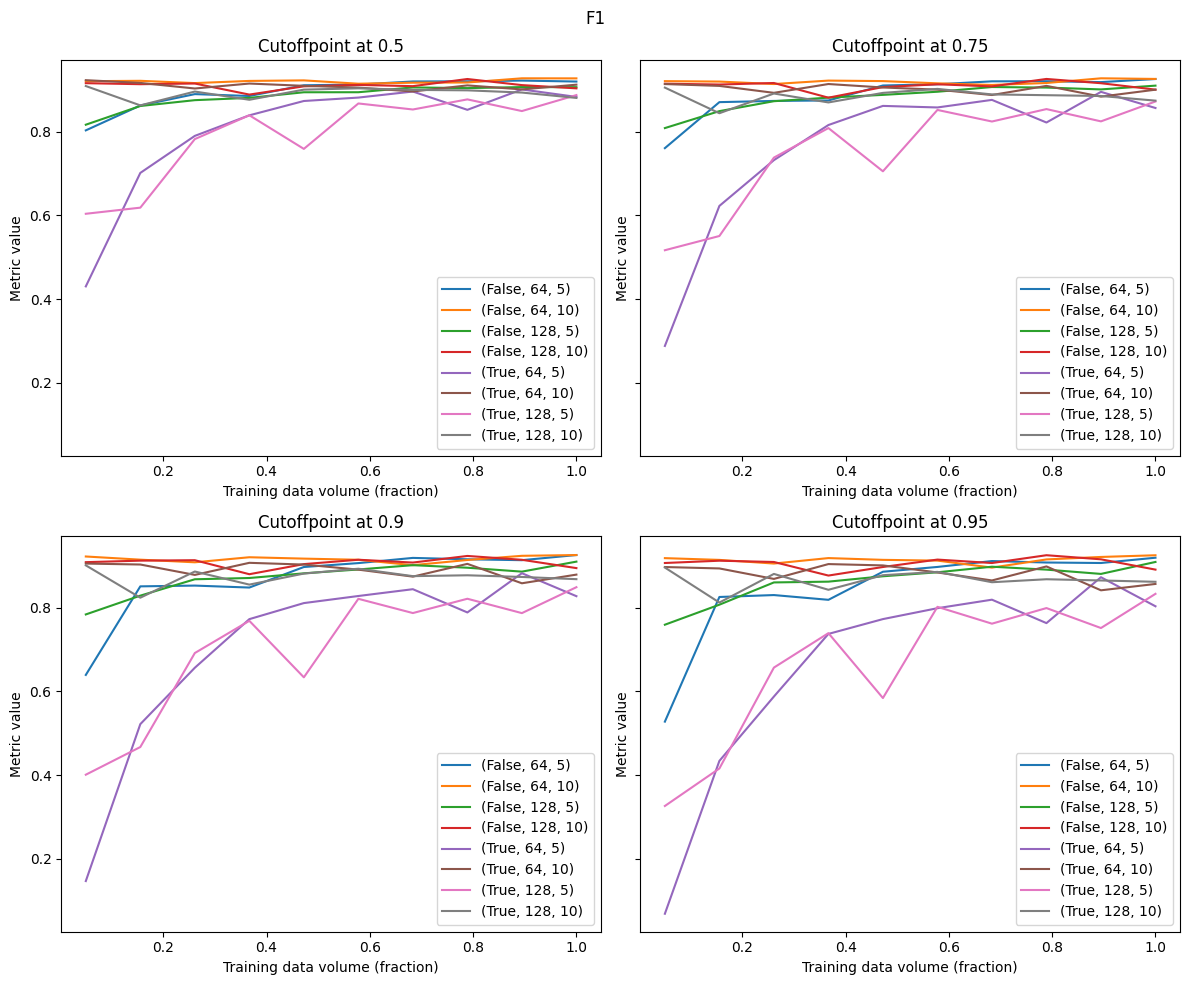

In [137]:
def plot_metric_grid(data, metric, fractions):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
    axs = axs.flatten()
    for i, (cutoff, model_values) in enumerate(data.items()):
        for hyperparameters, metric_values in model_values.items():
            y_values = metric_values[metric]
            axs[i].plot(fractions, y_values, label=f'{str(hyperparameters)}')        
        axs[i].set_title(f'Cutoffpoint at {cutoff}')
        axs[i].set_xlabel('Training data volume (fraction)')
        axs[i].set_ylabel('Metric value')
        axs[i].legend()

    # Adjust layout to prevent overlap
    plt.suptitle(metric)
    plt.tight_layout()
    plt.show()
plot_metric_grid(bin_results, 'F1', fractions)

Interesting: Models trained with the bounding box are worse off then models without bounding boxes; this could be to the issue signalled before: YOLO crops too tight which essentialy means it'll cut of part of the car in just the same way an image would be taken where the car is physcially cropped off. 

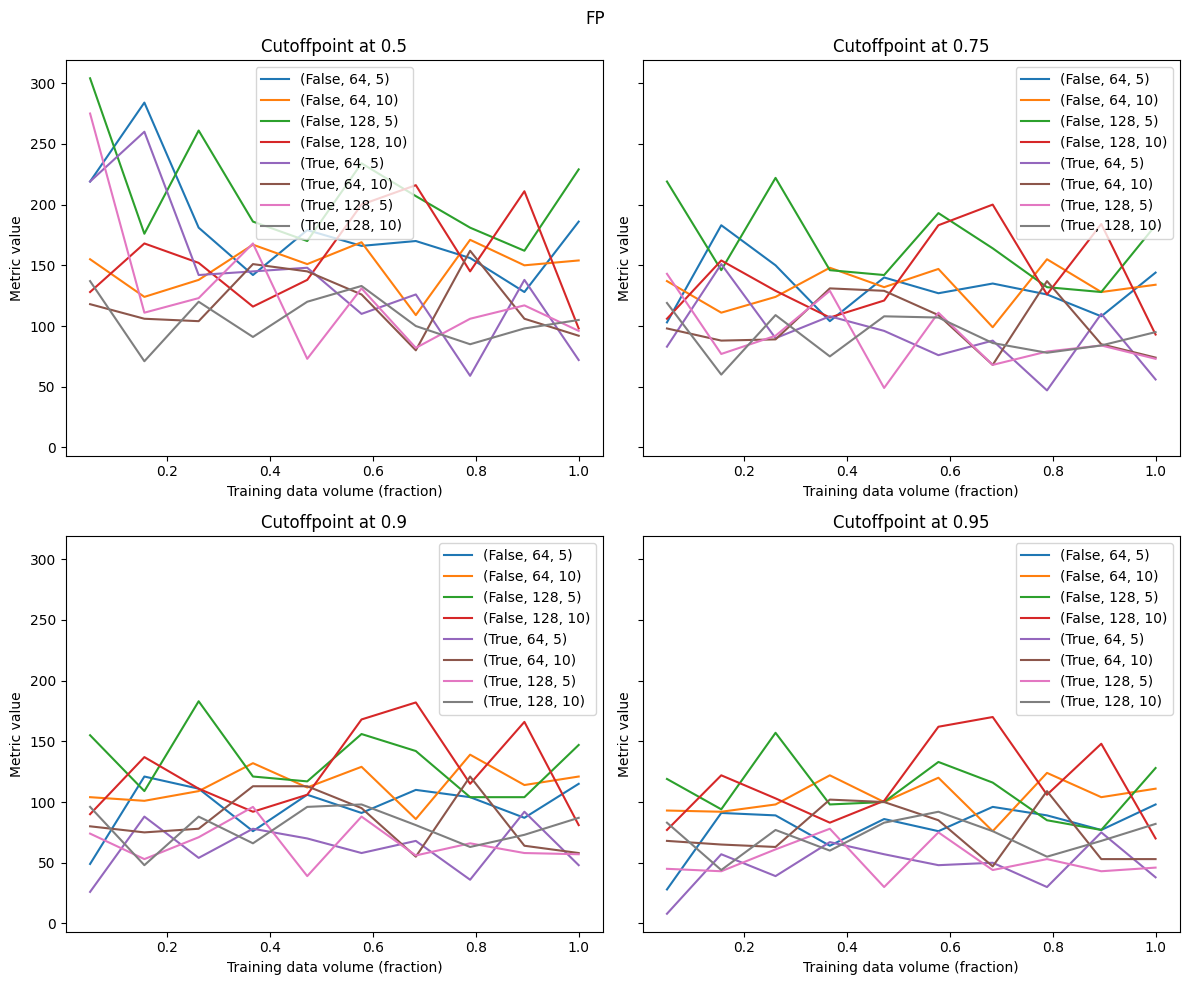

In [138]:
plot_metric_grid(bin_results, 'FP', fractions)

F1 score is not a bad metric, but I would like to keep the false positives to a minimum: When looking at this I come to other conclusions: Bounding Box is usefull (these systematiclaly have a lower rate of FP's)! 

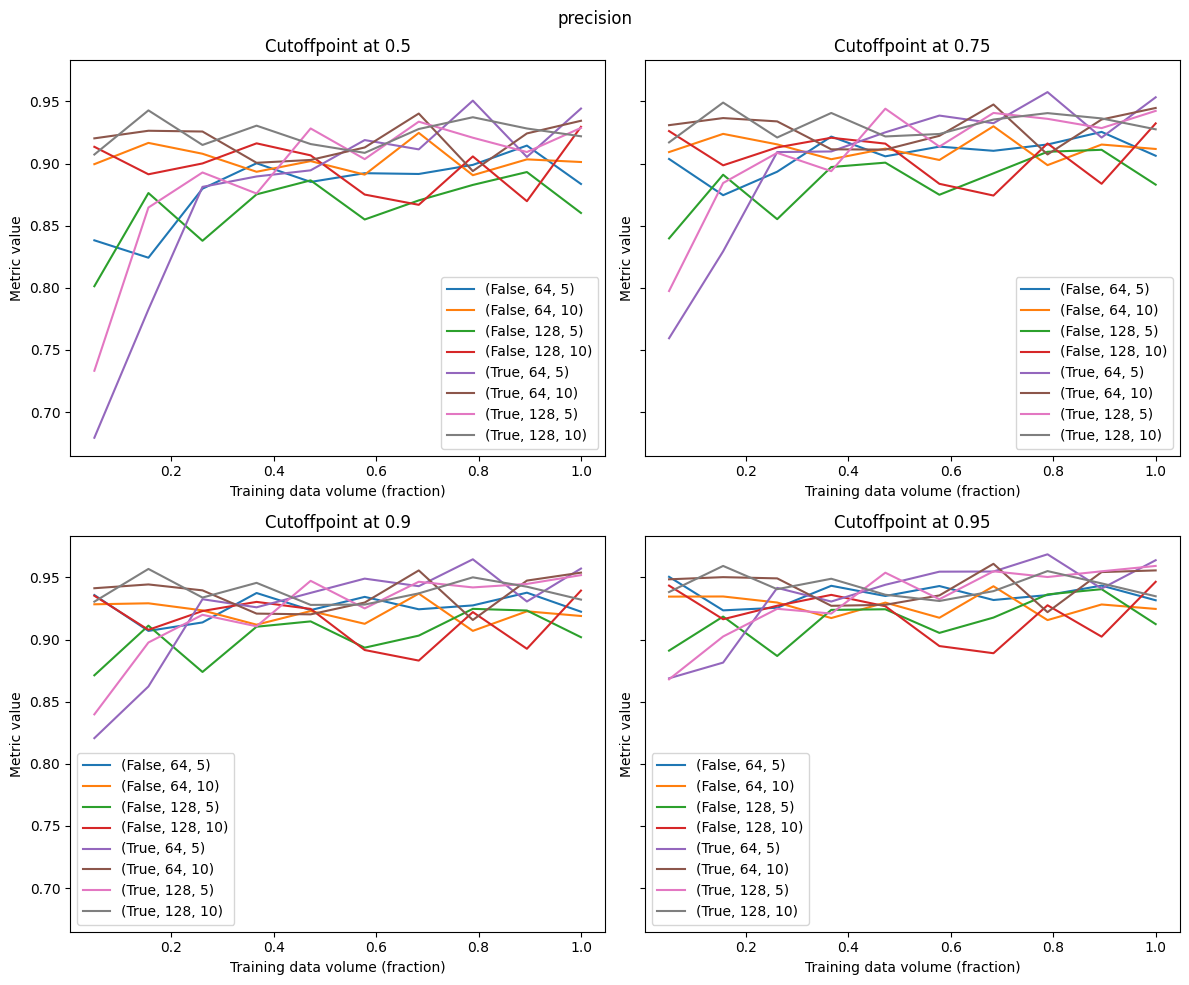

In [140]:
plot_metric_grid(bin_results, 'precision', fractions)

Three out of the four best performing model parameter combinations include using the Bounding Box when we look at the precision metric. So again BBOX seems to be important here. 

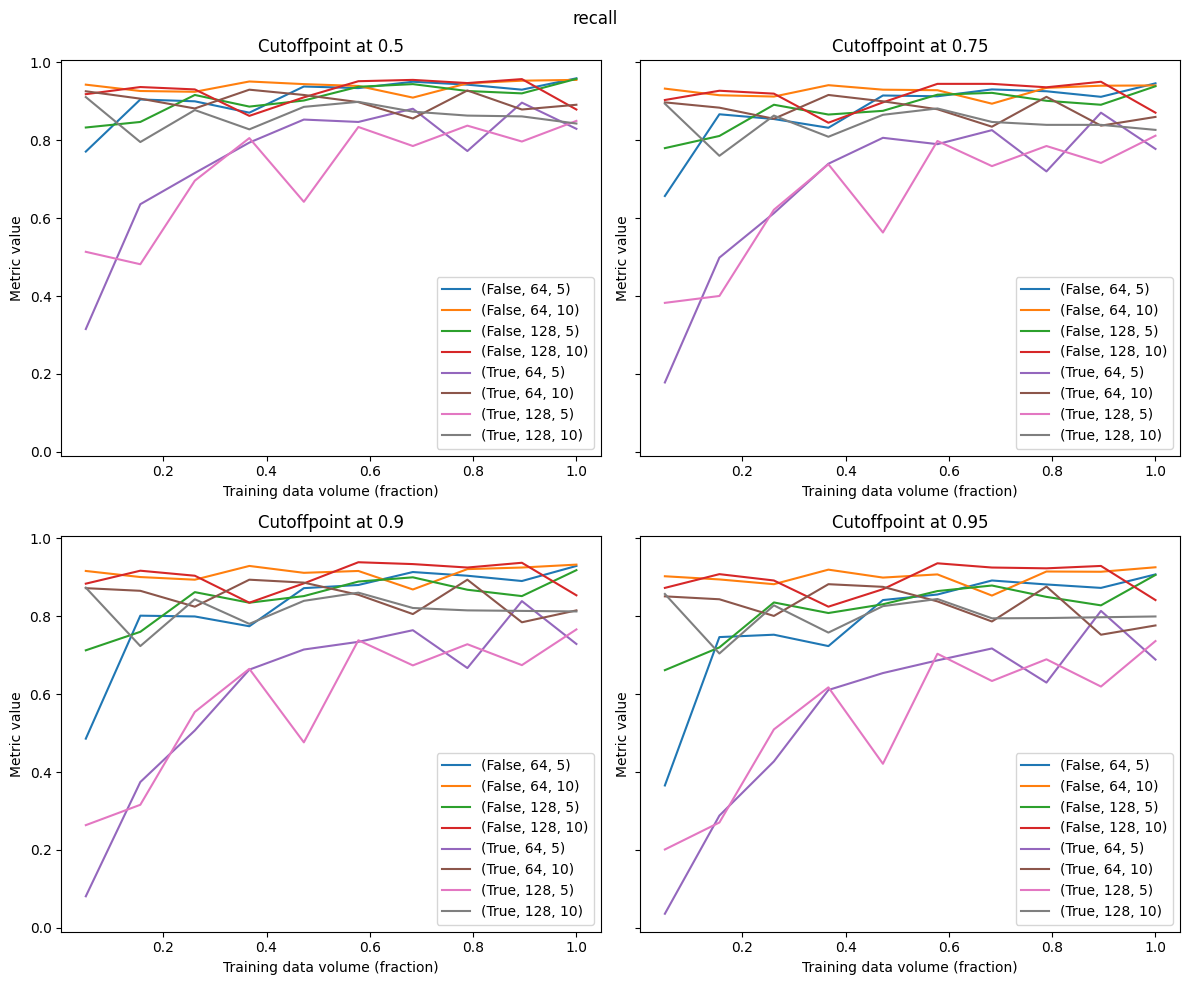

In [141]:
plot_metric_grid(bin_results, 'recall', fractions)

When looking at recall, models that were trained using bounding boxes score systematically poorer than unbounded counterparts. 

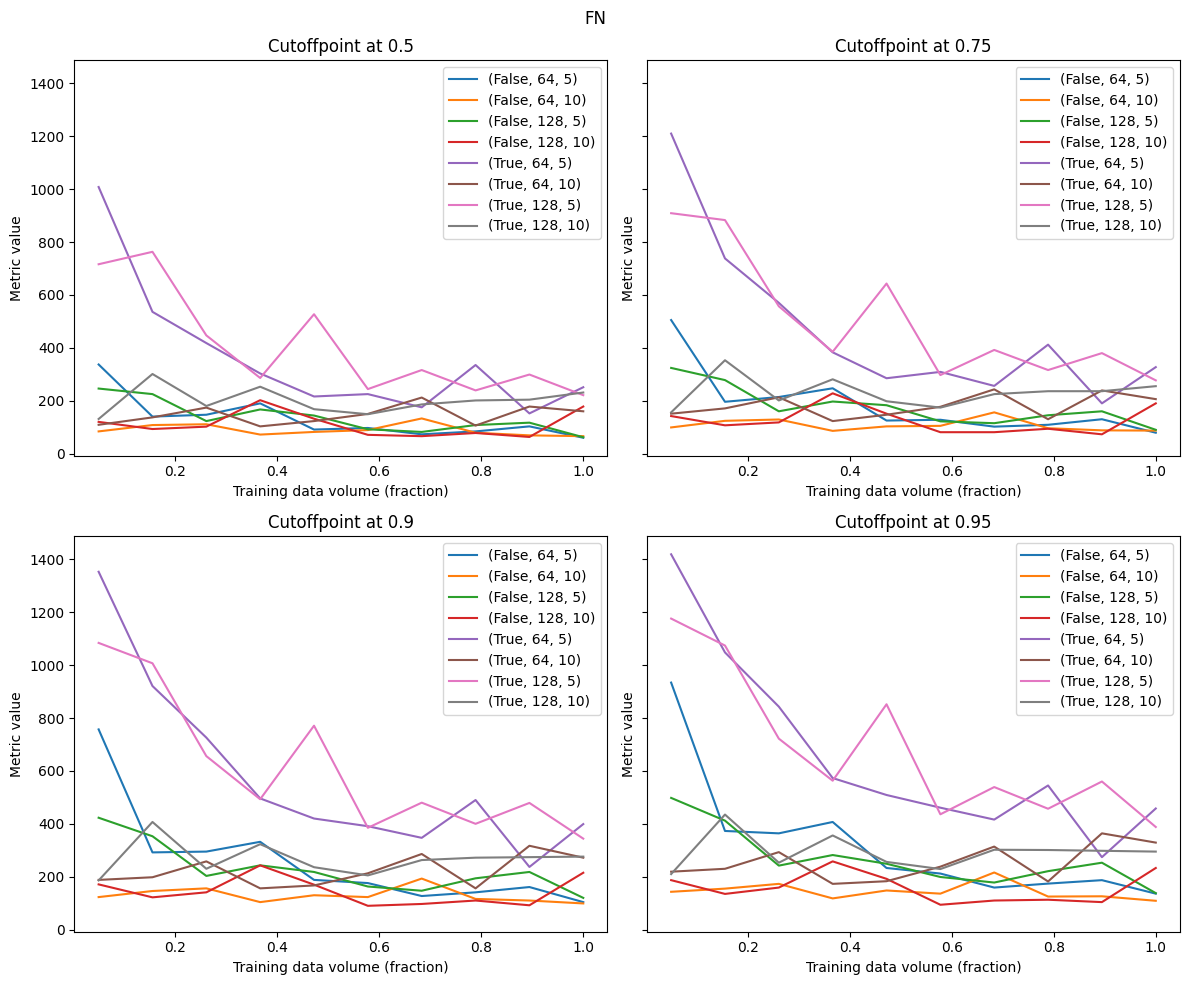

In [142]:
plot_metric_grid(bin_results, 'FN', fractions)

We have less false negatives if we use the entire image vs images that were cropped to use the bounding box returned by YOLO. 

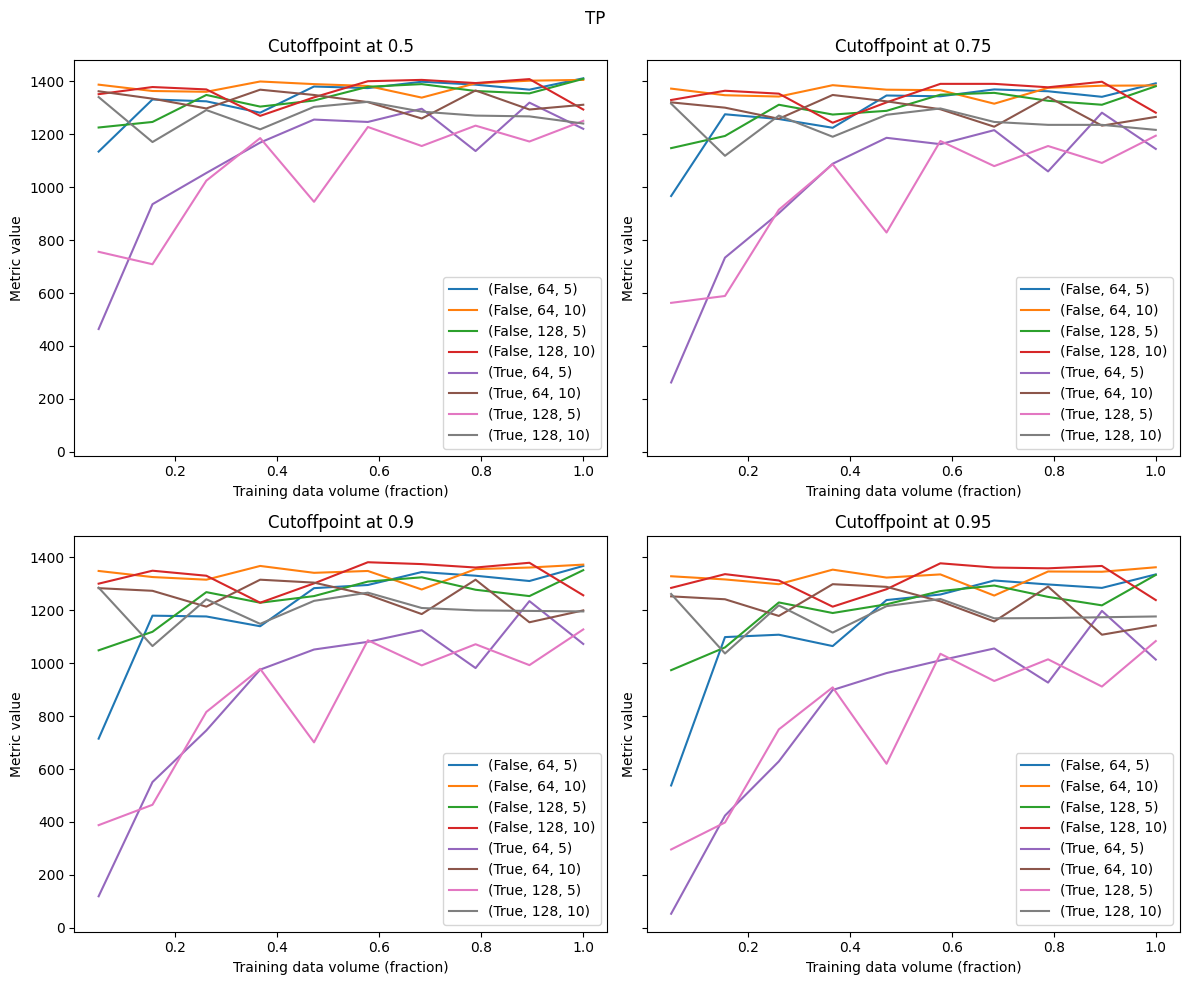

In [143]:
plot_metric_grid(bin_results, 'TP', fractions)

True positives score systematically higher if you don't use the Bounding boxed by YOLO

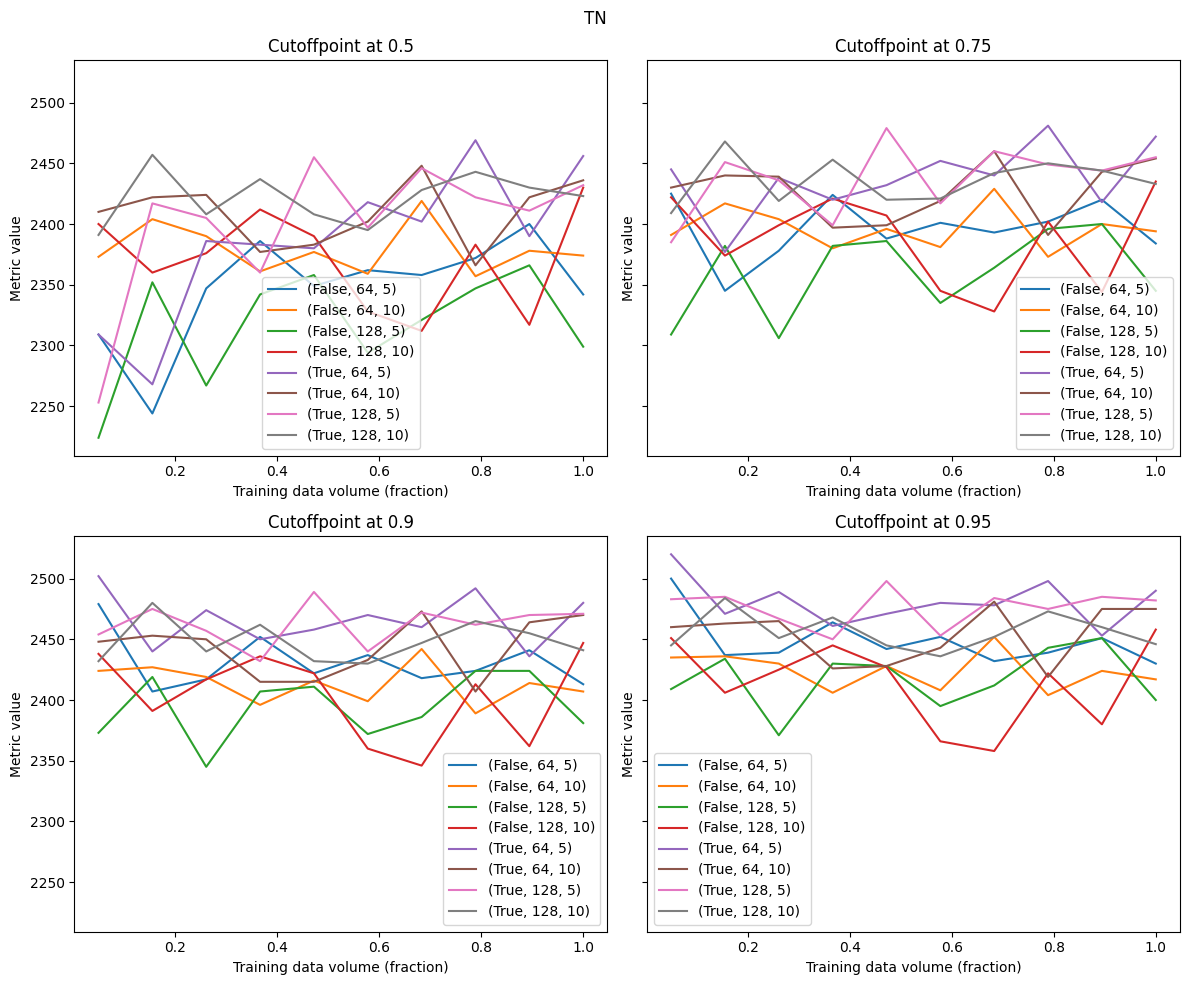

In [144]:

plot_metric_grid(bin_results, 'TN', fractions)

However, bounding boxes seem to be a helpful aid in identifying true negatives. 

## Conclusion: 

1) large volumes of data seem to be more beneficial for models trained with 5 epochs. Models trained on 10 epochs seem to benefit less from a growing volume of training data. (They still benefit; just less.)
2) Bounding boxes help or obstruct depending on the metric you use. My goal is to clean up the almost 16000000 images; I'd like to keep the amount of **False Positives** as low as possible. As such, based on graph plot with the FP metric the model trained WITH **BBOX == TRUE**, **RASTERSIZE == 64** and **EPOCHS == 5**(Purple) seems to perform the best. This is also the model with the worst F1 score; we can explain this by looking at the recall curves, where this purple model is also the worst. All it means is that out of all models it misslabels good images as crappy more than others (see also the FN curve, where the purple model scores significantly worse than other models).